In [ ]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
from jinja2 import Template
import mdtraj as md
try:
    workdir
except NameError:
    workdir=%pwd
else:
    %cd $workdir

### Download and compile [Faunus](https://faunus.readthedocs.io/en/latest/)

In [ ]:
%%bash -s "$workdir"
git clone https://github.com/mlund/faunus.git 
cd faunus
git checkout v2.4.0
cmake . -DENABLE_OPENMP=OFF -DCMAKE_BUILD_TYPE=Release
make -j4 faunus
cd $1

### Faunus input file

In [ ]:
template = Template("""comment: "Intimin."
temperature: {{T}}
random: {seed: hardware}
geometry: {type: slit, length: {{[L,L,L]}}}
mcloop: {macro: 100, micro: {{micro}}}

atomlist:
    - B: {sigma: 50, eps: 1, dp: 0}
    - D00: {sigma: 40, eps: 1, dp: 0}
    - L1: {sigma: 10, eps: 1, dp: 3}
    - D0: {sigma: 40, eps: 1, dp: 3}
    - L2: {sigma: 10, eps: 1, dp: 3}
    - D1: {sigma: 40, eps: 1, dp: 3}
    - L3: {sigma: 10, eps: 1, dp: 3}
    - D2: {sigma: 40, eps: 1, dp: 3}
    - L4: {sigma: 10, eps: 1, dp: 3}
    - D3: {sigma: 40, eps: 1, dp: 3}
    
moleculelist:
    - intimin:
        structure:
            - B: [0,0,{{5-L*0.5}}]
            - D00: [0,0,{{50-L*0.5}}]    
            - L1: [0,0,{{76-L*0.5}}]    
            - D0: [0,0,{{98-L*0.5}}]    
            - L2: [0,0,{{120-L*0.5}}]    
            - D1: [0,0,{{142-L*0.5}}]    
            - L3: [0,0,{{164-L*0.5}}]    
            - D2: [0,0,{{186-L*0.5}}] 
            - L4: [0,0,{{212-L*0.5}}]
            - D3: [0,0,{{238-L*0.5}}]
        bondlist:
            - harmonic: { index: [1,2], k: 1, req: 26 }
            - harmonic: { index: [2,3], k: 0.5, req: 21 }
            - harmonic: { index: [3,4], k: 0.5, req: 21 }
            - harmonic: { index: [4,5], k: 0.5, req: 21 }
            - harmonic: { index: [5,6], k: 0.5, req: 21 }
            - harmonic: { index: [6,7], k: 0.5, req: 21 }
            - harmonic: { index: [7,8], k: 0.5, req: 21 }
            - harmonic: { index: [8,9], k: 0.5, req: 21 }
            - harmonic_torsion: { index: [1,2,3], k: {{k}}, aeq: {{aeq}} }
            - harmonic_torsion: { index: [2,3,4], k: 30, aeq: 150 }
            - harmonic_torsion: { index: [3,4,5], k: 1, aeq: 110 }
            - harmonic_torsion: { index: [4,5,6], k: 30, aeq: 150 }
            - harmonic_torsion: { index: [5,6,7], k: 1, aeq: 110 }
            - harmonic_torsion: { index: [6,7,8], k: 30, aeq: 150 }
            - harmonic_torsion: { index: [7,8,9], k: 30, aeq: 150 }
        excluded_neighbours: 2
        keeppos: True
        rotate: False

insertmolecules:
    - intimin: {N: 1}

energy:
    - bonded: {}
    - nonbonded:
        default:
            - wca:
                mixing: LB 

moves:
    - transrot: {molecule: intimin, repeat: 8}
        
analysis:
    - savestate: {file: state.json}
    - savestate: {file: confout.pqr}
    - savestate: {file: confout.gro}
    - reactioncoordinate: {file: x.dat, nstep: 200, type: atom, property: x, index: 9}
    - reactioncoordinate: {file: y.dat, nstep: 200, type: atom, property: y, index: 9}
    - reactioncoordinate: {file: z.dat, nstep: 200, type: atom, property: z, index: 9}
    - xtcfile: {file: traj.xtc, nstep: 200}
    - sanity: {nstep: 10000}""")

Specify the path of the Faunus directory

In [ ]:
faunus_path = workdir+'/faunus'

### Run Monte Carlo simulation with a rigid D00-D0

In [ ]:
%%time
%cd $workdir
RT = 8.3145*.298
T = 298
!mkdir rigid
%cd rigid
with open('input.yml', 'w') as input_file:
    input_file.write(template.render(T=T, L=400, micro=8e6, k=30, aeq=150))
!{faunus_path}/scripts/yason.py input.yml > input.json
!{faunus_path}/faunus --input input.json --output output.json --nobar 
%cd ..

### Run Monte Carlo simulation with a flexible D00-D0

In [ ]:
%%time
!mkdir flexible50
%cd flexible50
with open('input.yml', 'w') as input_file:
    input_file.write(template.render(T=T, L=400, micro=8e6, k=2, aeq=110))
!{faunus_path}/scripts/yason.py input.yml > input.json
!{faunus_path}/faunus --input input.json --output output.json --nobar 
%cd ..

### Plot probability distributions of the domain–domain angle and the domain–linker separation

In [ ]:
model = 'rigid'
traj = md.load_xtc(model+'/traj.xtc',model+'/confout.gro')[100000:]
print(traj.n_frames)
r = md.compute_angles(traj,[[1,2,3]])/np.pi*180
edges = np.arange(r.min(),r.max(),1)
h, bins = np.histogram(r, bins=edges, density=True)
bins = bins[:-1] + (bins[1]-bins[0])/2.
np.savetxt('data/hist_cg_d00d1_rigid.dat',np.c_[bins,h])

model = 'flexible'
traj = md.load_xtc(model+'/traj.xtc',model+'/confout.gro')[100000:]
r = md.compute_angles(traj,[[1,2,3]])/np.pi*180
edges = np.arange(r.min(),r.max(),1)
h, bins = np.histogram(r, bins=edges, density=True)
bins = bins[:-1] + (bins[1]-bins[0])/2.
np.savetxt('data/hist_cg_d0d1_flexible.dat',np.c_[bins,h])

model = 'flexible'
r = md.compute_distances(traj,[[1,2]])
edges = np.arange(r.min(),r.max(),.01)
h, bins = np.histogram(r, bins=edges, density=True)
bins = bins[:-1] + (bins[1]-bins[0])/2.
np.savetxt('data/hist_cg_d00_flexible.dat',np.c_[bins,h])

model = 'flexible'
r = md.compute_distances(traj,[[2,3]])
edges = np.arange(r.min(),r.max(),.01)
h, bins = np.histogram(r, bins=edges, density=True)
bins = bins[:-1] + (bins[1]-bins[0])/2.
np.savetxt('data/hist_cg_d0_flexible.dat',np.c_[bins,h])

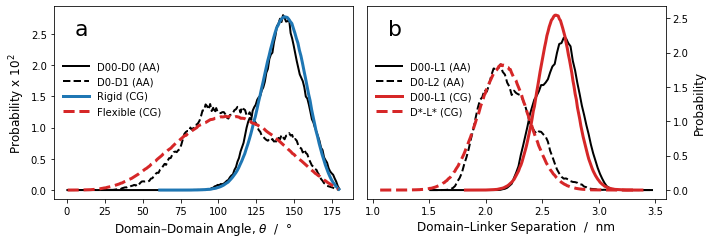

In [24]:
fig, (ax1,ax2) = plt.subplots(1, 2, sharex=False, sharey=False, figsize=(10,3.5))

bins,h = np.loadtxt('data/d00-d0_hist.dat',unpack=True)
ax1.plot(bins,h*1e2,color='k',lw=2,label='D00-D0 (AA)',ls='-')
bins,h = np.loadtxt('data/d0-d1_hist.dat',unpack=True)
ax1.plot(bins,h*1e2,color='k',lw=2,label='D0-D1 (AA)',ls='--')

bins,h = np.loadtxt('data/hist_cg_d00d1_rigid.dat',unpack=True)
ax1.plot(bins,h*1e2,color=plt.cm.tab10(0),lw=3,label='Rigid (CG)',ls='-')

bins,h = np.loadtxt('data/hist_cg_d0d1_flexible.dat',unpack=True)
ax1.plot(bins,h*1e2,color=plt.cm.tab10(3),lw=3,label='Flexible (CG)',ls='--')

###################################################

_,d = np.loadtxt('data/d00-d0_cm12.dat',unpack=True)
edges = np.arange(1.5,3.5,.02)
h, bins = np.histogram(d, bins=edges, density=True)
bins = bins[:-1] + (bins[1]-bins[0])/2.
ax2.plot(bins,h,color='k',lw=2,label='D00-L1 (AA)')
_,d = np.loadtxt('data/d0-d1_cm12.dat',unpack=True)
h, bins = np.histogram(d, bins=edges, density=True)
bins = bins[:-1] + (bins[1]-bins[0])/2.
ax2.plot(bins,h,color='k',lw=2,ls='--',label='D0-L2 (AA)')

bins,h = np.loadtxt('data/hist_cg_d00_flexible.dat',unpack=True)
ax2.plot(bins,h,color=plt.cm.tab10(3),lw=3,label='D00-L1 (CG)',ls='-')

bins,h = np.loadtxt('data/hist_cg_d0_flexible.dat',unpack=True)
ax2.plot(bins,h,color=plt.cm.tab10(3),lw=3,label='D*-L* (CG)',ls='--')

ax1.set_ylabel('Probability x 10$^2$')
ax1.set_xlabel(r'Domain–Domain Angle, $\theta$  /  $\degree$')#,labelpad=10)

ax2.set_ylabel('Probability')
ax2.set_xlabel('Domain–Linker Separation  /  nm')#,labelpad=10)

ax2.yaxis.set_label_position("right")
ax2.yaxis.set_ticks_position('right')

ax1.annotate('a',xy=(.07,.85),fontsize=22,xycoords='axes fraction')
ax2.annotate('b',xy=(.07,.85),fontsize=22,xycoords='axes fraction')

ax1.legend(frameon=False,title='\n',handlelength=2.6)
ax2.legend(frameon=False,title='\n',handlelength=2.6)

plt.tight_layout()
plt.savefig('figs/figureS6.pdf')
plt.show()

### Plot 1D and 2D probability distributions of the angle w.r.t. the normal and the D3–D00 separation

In [5]:
def hist(model,color,label):
    x = np.loadtxt(model+'/x.dat',usecols=1)[100000:]/10. 
    y = np.loadtxt(model+'/y.dat',usecols=1)[100000:]/10. 
    z = np.loadtxt(model+'/z.dat',usecols=1)[100000:]/10.+15
    r = np.sqrt(x**2+y**2+z**2)
    alpha = np.arccos(z/r)/np.pi*180
    edgesx = np.arange(3,18,.5)
    Ex = edgesx[:-1]+(edgesx[1]-edgesx[0])/2.
    edgesy = np.arange(0,150,5)
    Ey = edgesy[:-1]+(edgesy[1]-edgesy[0])/2.
    
    h, _ = np.histogram(r, bins=edgesx, density=True)
    ax1.plot(Ex,h*10,color=color,lw=2,label=label)
    np.savetxt('figs/hist_dist_{:s}.dat'.format(model),np.c_[Ex,h])
    
    h, _ = np.histogram(alpha, bins=edgesy, density=True)
    ax2.plot(Ey,h*100,color=color)
    np.savetxt('figs/hist_angle_{:s}.dat'.format(model),np.c_[Ey,h])
    
def prob(ax,model,color):
    x = np.loadtxt(model+'/x.dat',usecols=1)[100000:]/10. 
    y = np.loadtxt(model+'/y.dat',usecols=1)[100000:]/10. 
    z = np.loadtxt(model+'/z.dat',usecols=1)[100000:]/10.+15
    r = np.sqrt(x**2+y**2+z**2)
    alpha = np.arccos(z/r)/np.pi*180
    edgesx = np.arange(3,18,.5)
    Ex = edgesx[:-1]+(edgesx[1]-edgesx[0])/2.
    edgesy = np.arange(0,150,5)
    Ey = edgesy[:-1]+(edgesy[1]-edgesy[0])/2.
    
    h, _, _ = np.histogram2d(alpha,r,bins=[edgesy,edgesx], density=True)

    im = ax.contourf(Ex, Ey, h*1000, 10, cmap=color)
    np.savetxt('figs/hist_2d_{:s}_Ex.dat'.format(model),Ex)
    np.savetxt('figs/hist_2d_{:s}_Ey.dat'.format(model),Ey)
    np.savetxt('figs/hist_2d_{:s}.dat'.format(model),h)
    return im

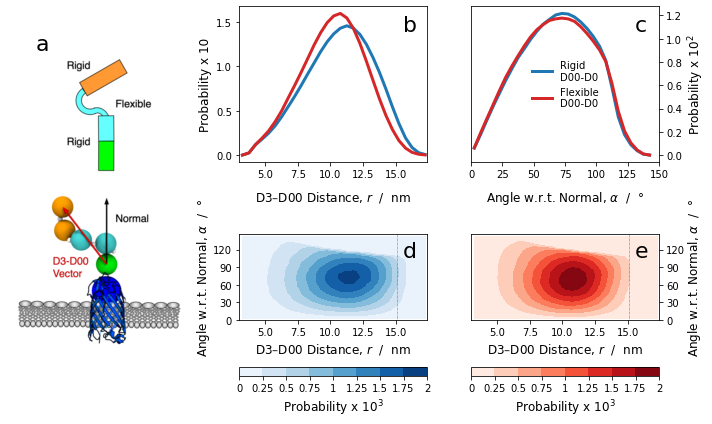

In [23]:
plt.rcParams['axes.labelsize'] = 12

ax0 = plt.subplot2grid(shape=(2,3), loc=(0,0), colspan=1, rowspan=2, fig=plt.figure(figsize=(10,6)))
ax1 = plt.subplot2grid((2,3), (0,1))
ax2 = plt.subplot2grid((2,3), (0,2))
ax3 = plt.subplot2grid((2,3), (1,1))
ax4 = plt.subplot2grid((2,3), (1,2))

I = plt.imread('figs/cg_model.png')
ax0.imshow(I[:-10,800:-1050], interpolation='bilinear')
ax0.axis('off')

model = 'rigid'
bins,h = np.loadtxt('data/hist_dist_{:s}.dat'.format(model),unpack=True)
ax1.plot(bins,h*10,color=plt.cm.tab10(0),lw=3)
bins,h = np.loadtxt('data/hist_angle_{:s}.dat'.format(model),unpack=True)
ax2.plot(bins,h*1e2,color=plt.cm.tab10(0),lw=3,label='Rigid\nD00-D0')


model = 'flexible'
bins,h = np.loadtxt('data/hist_dist_{:s}.dat'.format(model),unpack=True)
ax1.plot(bins,h*10,color=plt.cm.tab10(3),lw=3)
bins,h = np.loadtxt('data/hist_angle_{:s}.dat'.format(model),unpack=True)
ax2.plot(bins,h*1e2,color=plt.cm.tab10(3),lw=3,label='Flexible\nD00-D0')
ax2.set_xlim(0,150)
ax1.set_xlim(3,17.4)
ax1.set_ylabel(r'Probability x 10')
ax1.set_xlabel(r'D3–D00 Distance, $r$  /  nm',labelpad=10)
ax2.set_ylabel(r'Probability x 10$^2$')
ax2.set_xlabel(r'Angle w.r.t. Normal, $\alpha$  /  $\degree$',labelpad=10)


ax2.yaxis.set_label_position("right")
ax2.yaxis.set_ticks_position('right')

model = 'rigid'
Ex = np.loadtxt('data/hist_2d_{:s}_Ex.dat'.format(model))
Ey = np.loadtxt('data/hist_2d_{:s}_Ey.dat'.format(model))
h = np.loadtxt('data/hist_2d_{:s}.dat'.format(model))
im = ax3.contourf(Ex, Ey, h*1e3, cmap=plt.cm.Blues)
cbar = fig.colorbar(im,ax=ax3,label='Probability x 10$^3$',orientation='horizontal',pad=.3)
cbar.ax.set_xticklabels(['{:g}'.format(t) for t in np.arange(0,2.1,.25)])

model = 'flexible'    
Ex = np.loadtxt('data/hist_2d_{:s}_Ex.dat'.format(model))
Ey = np.loadtxt('data/hist_2d_{:s}_Ey.dat'.format(model))
h = np.loadtxt('data/hist_2d_{:s}.dat'.format(model))
im = ax4.contourf(Ex, Ey, h*1e3, cmap=plt.cm.Reds)
cbar = fig.colorbar(im,ax=ax4,label='Probability x 10$^3$',orientation='horizontal',pad=.3,)
cbar.ax.set_xticklabels(['{:g}'.format(t) for t in np.arange(0,2.1,.25)])
ax3.set_ylim(0,146)
ax4.set_ylim(0,146)
ax3.set_xlim(3,17.4)
ax4.set_xlim(3,17.4)
ax3.set_yticks([0,30,60,90,120])
ax4.set_yticks([0,30,60,90,120])

ax3.vlines(15.1,0,146,lw=.5,ls=':')
ax4.vlines(15.1,0,146,lw=.5,ls=':')

ax3.set_xlabel(r'D3–D00 Distance, $r$  /  nm')
ax3.set_ylabel(r'Angle w.r.t. Normal, $\alpha$  /  $\degree$',labelpad=1)

ax4.set_xlabel(r'D3–D00 Distance, $r$  /  nm')
ax4.set_ylabel(r'Angle w.r.t. Normal, $\alpha$  /  $\degree$',labelpad=1)

ax4.yaxis.set_label_position("right")
ax4.yaxis.set_ticks_position('right')

ax0.annotate('a',xy=(.15,.98),fontsize=22,xycoords='axes fraction')

for ax,l in zip([ax1,ax2],['b','c']):
    ax.annotate(l,xy=(.87,.84),fontsize=22,xycoords='axes fraction')
for ax,l in zip([ax3,ax4],['d','e']):
    ax.annotate(l,xy=(.87,.73),fontsize=22,xycoords='axes fraction')
ax2.legend(frameon=False,loc='center')

plt.tight_layout(h_pad = -1, w_pad = 0)
plt.savefig('figs/figure6.png',dpi=300)

## Jacobian Correction

The histograms are divided by the square of the distance and the sine of the angle to remove geometric entropy contributions.
The probability distributions are normalized according to the following equations:

$$
\int_0^\infty \mathrm{d}r P(r) r^2 = 1
$$

$$
\int_0^{180^\circ} \mathrm{d}\alpha P(\alpha) \sin{\alpha} = 1
$$

$$
\int_0^\infty \int_0^{180^\circ} \mathrm{d}r \mathrm{d}\alpha P(r,\alpha) r^2 \sin{\alpha} = 1
$$

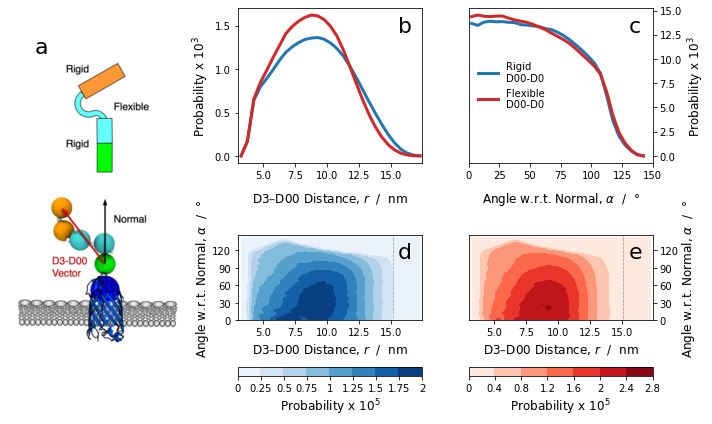

In [22]:
plt.rcParams['axes.labelsize'] = 12

ax0 = plt.subplot2grid(shape=(2,3), loc=(0,0), colspan=1, rowspan=2, fig=plt.figure(figsize=(10,6)))
ax1 = plt.subplot2grid((2,3), (0,1))
ax2 = plt.subplot2grid((2,3), (0,2))
ax3 = plt.subplot2grid((2,3), (1,1))
ax4 = plt.subplot2grid((2,3), (1,2))

I = plt.imread('figs/cg_model.png')
ax0.imshow(I[:-10,800:-1050], interpolation='bilinear')
ax0.axis('off')

model = 'rigid'
bins,h = np.loadtxt('data/hist_dist_{:s}.dat'.format(model),unpack=True)
h /= bins**2 # Jacobian correction
ax1.plot(bins,h*1e3,color=plt.cm.tab10(0),lw=3)
bins,h = np.loadtxt('data/hist_angle_{:s}.dat'.format(model),unpack=True)
h /= np.sin(bins/180*np.pi) # Jacobian correction
ax2.plot(bins,h*1e3,color=plt.cm.tab10(0),lw=3,label='Rigid\nD00-D0')


model = 'flexible'
bins,h = np.loadtxt('data/hist_dist_{:s}.dat'.format(model),unpack=True)
h /= bins**2 # Jacobian correction
ax1.plot(bins,h*1e3,color=plt.cm.tab10(3),lw=3)
bins,h = np.loadtxt('data/hist_angle_{:s}.dat'.format(model),unpack=True)
h /= np.sin(bins/180*np.pi) # Jacobian correction
ax2.plot(bins,h*1e3,color=plt.cm.tab10(3),lw=3,label='Flexible\nD00-D0')
ax2.set_xlim(0,150)
ax1.set_xlim(3,17.4)
ax1.set_ylabel(r'Probability x 10$^3$')
ax1.set_xlabel(r'D3–D00 Distance, $r$  /  nm',labelpad=10)
ax2.set_ylabel(r'Probability x 10$^3$')
ax2.set_xlabel(r'Angle w.r.t. Normal, $\alpha$  /  $\degree$',labelpad=10)


ax2.yaxis.set_label_position("right")
ax2.yaxis.set_ticks_position('right')

model = 'rigid'
Ex = np.loadtxt('data/hist_2d_{:s}_Ex.dat'.format(model))
Ey = np.loadtxt('data/hist_2d_{:s}_Ey.dat'.format(model))
h = np.loadtxt('data/hist_2d_{:s}.dat'.format(model))
h /= (Ex*Ex*np.sin(Ey/180*np.pi).reshape(-1,1)) # Jacobian correction
im = ax3.contourf(Ex, Ey, h*1e5, cmap=plt.cm.Blues)
cbar = fig.colorbar(im,ax=ax3,label='Probability x 10$^5$',orientation='horizontal',pad=.3)
cbar.ax.set_xticklabels(['{:g}'.format(t) for t in np.arange(0,2.1,.25)])

model = 'flexible'    
Ex = np.loadtxt('data/hist_2d_{:s}_Ex.dat'.format(model))
Ey = np.loadtxt('data/hist_2d_{:s}_Ey.dat'.format(model))
h = np.loadtxt('data/hist_2d_{:s}.dat'.format(model))
h /= (Ex*Ex*np.sin(Ey/180*np.pi).reshape(-1,1)) # Jacobian correction
im = ax4.contourf(Ex, Ey, h*1e5, cmap=plt.cm.Reds)
cbar = fig.colorbar(im,ax=ax4,label='Probability x 10$^5$',orientation='horizontal',pad=.3,)
cbar.ax.set_xticklabels(['{:g}'.format(t) for t in np.arange(0,2.9,.4)])
ax3.set_ylim(0,146)
ax4.set_ylim(0,146)
ax3.set_xlim(3,17.4)
ax4.set_xlim(3,17.4)
ax3.set_yticks([0,30,60,90,120])
ax4.set_yticks([0,30,60,90,120])

ax3.vlines(15.1,0,146,lw=.5,ls=':')
ax4.vlines(15.1,0,146,lw=.5,ls=':')

ax3.set_xlabel(r'D3–D00 Distance, $r$  /  nm')
ax3.set_ylabel(r'Angle w.r.t. Normal, $\alpha$  /  $\degree$',labelpad=1)

ax4.set_xlabel(r'D3–D00 Distance, $r$  /  nm')
ax4.set_ylabel(r'Angle w.r.t. Normal, $\alpha$  /  $\degree$',labelpad=1)

ax4.yaxis.set_label_position("right")
ax4.yaxis.set_ticks_position('right')

ax0.annotate('a',xy=(.15,.98),fontsize=22,xycoords='axes fraction')

for ax,l in zip([ax1,ax2],['b','c']):
    ax.annotate(l,xy=(.87,.84),fontsize=22,xycoords='axes fraction')
for ax,l in zip([ax3,ax4],['d','e']):
    ax.annotate(l,xy=(.87,.73),fontsize=22,xycoords='axes fraction')
ax2.legend(frameon=False,loc='center left')

plt.tight_layout(h_pad = -1, w_pad = 0)
plt.savefig('figs/figure6Jac.png',dpi=300)

### Figure 4

<Figure size 432x288 with 0 Axes>

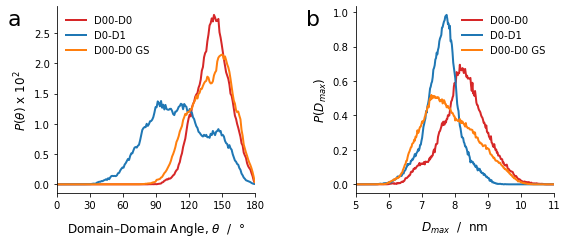

In [21]:
fig = plt.figure()

fig, (ax1,ax2) = plt.subplots(1, 2, sharex=False, sharey=False, figsize=(8,3.5))

bins,h = np.loadtxt('data/d00-d0_hist.dat',unpack=True)
ax1.plot(bins,h*1e2,color=plt.cm.tab10(3),lw=2,label='D00-D0')
#popt,_ = curve_fit(gaussian,bins,h,bounds=((80,.0),(180,1)))
#print(popt)
#ax1.plot(bins,gaussian(bins,*popt),color='r',lw=1)
bins,h = np.loadtxt('data/d0-d1_hist.dat',unpack=True)
ax1.plot(bins,h*1e2,color=plt.cm.tab10(0),lw=2,ls='-',label='D0-D1')

have = np.zeros(h.size)
for i in [0,1,2,3,4]:
    bins,h = np.loadtxt('data/int-GS{:d}_hist.dat'.format(i),unpack=True)
    have += h*1e2
ax1.plot(bins,have/5,color=plt.cm.tab10(1),lw=2,label='D00-D0 GS')

#popt,_ = curve_fit(gaussian,bins,h,bounds=((80,.0),(180,1)))
#print(popt)
#ax1.plot(bins,gaussian(bins,*popt),color='r',lw=1)
ax1.legend(frameon=False)
ax1.set_xlim(0,180)
ax1.set_ylabel(r'$P(\theta)$ x 10$^2$')
ax1.set_xlabel(r'Domain–Domain Angle, $\theta$  /  $\degree$',labelpad=10)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)


d = np.loadtxt('data/d00-d0_Dmax.dat',usecols=1)[10000:]
edges = np.arange(5,11,.02)
h, bins = np.histogram(d, bins=edges, density=True)
bins = bins[:-1] + (bins[1]-bins[0])/2.
ax2.plot(bins,h,color=plt.cm.tab10(3),lw=2,label='D00-D0')
d = np.loadtxt('data/d0-d1_Dmax.dat',usecols=1)[10000:]
h, bins = np.histogram(d, bins=edges, density=True)
bins = bins[:-1] + (bins[1]-bins[0])/2.
ax2.plot(bins,h,color=plt.cm.tab10(0),lw=2,ls='-',label='D0-D1')

have = np.zeros(h.size)
for i in [0,1,2,3,4]:
    d = np.loadtxt('data/int-GS{:d}_Dmax.dat'.format(i),usecols=1)[10000:]
    h, bins = np.histogram(d, bins=edges, density=True)
    bins = bins[:-1] + (bins[1]-bins[0])/2.
    have += h
ax2.plot(bins,have/5,color=plt.cm.tab10(1),lw=2,label='D00-D0 GS')

ax2.legend(frameon=False)
ax2.set_ylabel(r'$P(D_{max})$')
ax2.set_xlabel(r'$D_{max}$  /  nm',labelpad=10)
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)

ax2.set_xlim(5,11)

ax1.set_xticks(range(0,181,30))
ax2.set_xticks(range(5,12,1))

ax1.annotate('a',xy=(-.25,.9),fontsize=22,xycoords='axes fraction')
ax2.annotate('b',xy=(-.25,.9),fontsize=22,xycoords='axes fraction')

plt.tight_layout(w_pad=4)
plt.savefig('figs/figure4.pdf')
plt.show()